Messo in questa directory temporaneamente perchè non mi funziona l'import per la funzione *read_data*

In [31]:
import pandas as pd
import sklearn

from Analysis.model.helper import *
from Analysis.resources.costants import RESOURCES_DIRECTORY


In [32]:
folder_name = "additional_analysis"

data = pd.read_csv(os.path.join(RESOURCES_DIRECTORY,"data.csv"))

# drops rows with duplicat Name, since conditioning and nnz is the same
unique_data = data.drop_duplicates(subset='Name', keep="first")
unique_data


,Name,Rows,Columns,Error,Memory,Time,Language,OS,Nnz,Cond
0,apache2,715176,715176,2.235941e-08,0.004471,66.232192,1,0,4817870,5.316861e+06
4,cfd1,70656,70656,6.628463e-12,0.003326,4.461982,1,0,1825580,1.335081e+06
8,cfd2,123440,123440,1.334161e-10,0.003326,10.917099,1,0,3085406,3.728473e+06
12,ex15,6867,6867,5.281170e-05,0.003326,0.015078,1,0,98671,1.432642e+13
16,G3_circuit,1585478,1585478,3.452568e-09,210.620559,27.939265,1,0,7660826,2.238425e+07
20,parabolic_fem,525825,525825,8.836779e-10,0.003326,6.439602,1,0,3674625,2.110820e+05
24,shallow_water1,81920,81920,6.923992e-14,9.067514,0.615064,1,0,327680,3.628000e+00


Il file *data_aggregation.csv* contiene un'aggregazione dei dati delle matrici, con le proprietà fisse che restano invariate, mentre time, memory ed error, che variano a seconda di OS e linguaggio, vengono aggregate attraverso una media separata tra i due linguaggi di programmazione, calcolata sia per MATLAB che per Python. Vengono quindi aggregati i dati dei diversi OS, oltre che erchè molto simili, anche per risparmiare nel numero di colonne, essendo già di più delle righe

Ne scaturisce una tabella di 7 righe: una per ciascuna matrice, senza righe duplicate

Sarà utile in seguito per alcune analisi effettuate, soprattuto il clustering

In [33]:
from Analysis.resources.costants import RESOURCES_DIRECTORY

data = pd.read_csv(os.path.join(RESOURCES_DIRECTORY,"data.csv"))
unique_data = data.drop_duplicates(subset='Name', keep="first")
matrix_names = unique_data.Name.tolist()
agg_data = pd.DataFrame(columns=["Name", "Rows", "errorMat", "errorPy", "memoryMat", "memoryPy", "timeMat", "timePy", "Nnz", "Cond"])

for i in range(len(matrix_names)):
    name = unique_data.iloc[i].Name     # name of the i-th matrix
    
    sub_data_mat = data[(data.Name == name) & (data.Language == 0)]     # df of 2 rows for the current matrix in MATLAB
    sub_data_py = data[(data.Name == name) & (data.Language == 1)]      # df of 2 rows for the current matrix in Python

    error_mat = sub_data_mat["Error"].mean()      # error average just for MATLAB
    error_py = sub_data_py["Error"].mean()        # error average just for Python

    memory_mat = sub_data_mat["Memory"].mean()      # memory average just for MATLAB
    memory_py = sub_data_py["Memory"].mean()        # memory average just for Python

    time_mat = sub_data_mat["Time"].mean()      # time average just for MATLAB
    time_py = sub_data_py["Time"].mean()        # time average just for Python

    agg_data.loc[i] = [unique_data.iloc[i].Name, unique_data.iloc[i].Rows, error_mat, error_py, memory_mat, memory_py, 
                        time_mat, time_py, unique_data.iloc[i].Nnz, unique_data.iloc[i].Cond]

agg_data.to_csv("data_aggregation.csv", index=False)
agg_data

,Name,Rows,errorMat,errorPy,memoryMat,memoryPy,timeMat,timePy,Nnz,Cond
0,apache2,715176,4.388900e-11,2.235941e-08,2823.50505,65.695641,14.288000,74.802496,4817870,5.316861e+06
1,cfd1,70656,1.135900e-13,6.628463e-12,569.08860,24.734949,2.640650,4.922319,1825580,1.335081e+06
2,cfd2,123440,3.348600e-13,1.334161e-10,1166.58845,0.003326,6.162600,12.200138,3085406,3.728473e+06
3,ex15,6867,6.348200e-07,5.281170e-05,1.80840,1.333975,0.027761,0.018617,98671,1.432642e+13
4,G3_circuit,1585478,3.576600e-12,3.452568e-09,3233.09475,105.311943,19.193450,30.874976,7660826,2.238425e+07
5,parabolic_fem,525825,1.050000e-12,8.836779e-10,573.02630,0.003326,3.160100,7.180180,3674625,2.110820e+05
6,shallow_water1,81920,2.672800e-16,6.923992e-14,20.78310,4.535420,0.258710,0.680383,327680,3.628000e+00


# Come cresce l'Errore Relativo al crescere del Condizionamento?

Qui vengono mostrati Plot e Barplot, e successivamente nel dettaglio il cofficiente di correlazione, nelle 4 combinazioni linguaggio-OS 

(Terrei entrambe le tipologie di grafico per la documentazione Latex)

Come ci si poteva aspettare, la crescita dell'errore è direttamente proporzionale alla crescita del condizionamento della matrice: per questo ex15, pur essendo la matrice più piccola, è quella con errore più grande

(Dal momento che il condizionamento è stato calcolato su MATLAB, l'errore considerato è quello di MATLAB, OS Windows ma era indifferente dal momento che le analisi hanno evidenziato che gli errori non cambiano tra diversi OS)

C:\Users\simon\AppData\Local\Temp\ipykernel_808\324096884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data.sort_values(by="Cond", inplace=True)


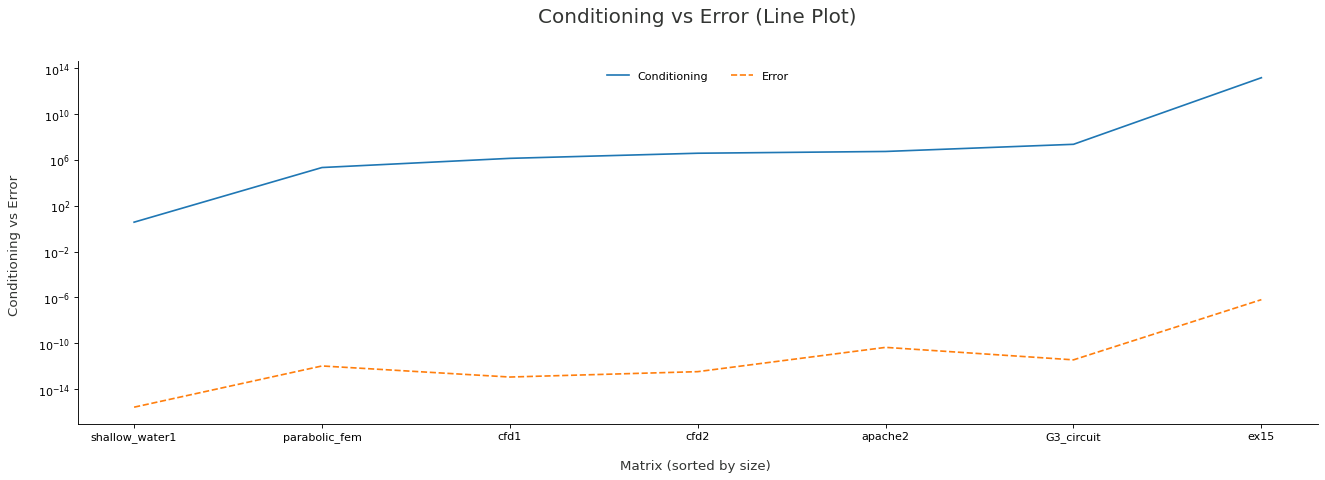

In [34]:
sub_data = data[(data.OS == 0) & (data.Language == 0)] #matlab

sub_data.sort_values(by="Cond", inplace=True)

cond_list = sub_data.Cond.tolist()
error_list = sub_data.Error.tolist()

matrix_names = sub_data.Name.tolist()

path = get_figures_path(folder_name, "cond_error_matlab_line.png")
plot(matrix_names, cond_list, error_list, "Matrix (sorted by size)", "Conditioning vs Error", "Conditioning vs Error", "Conditioning", "Error", path, LOG_SCALE=True)

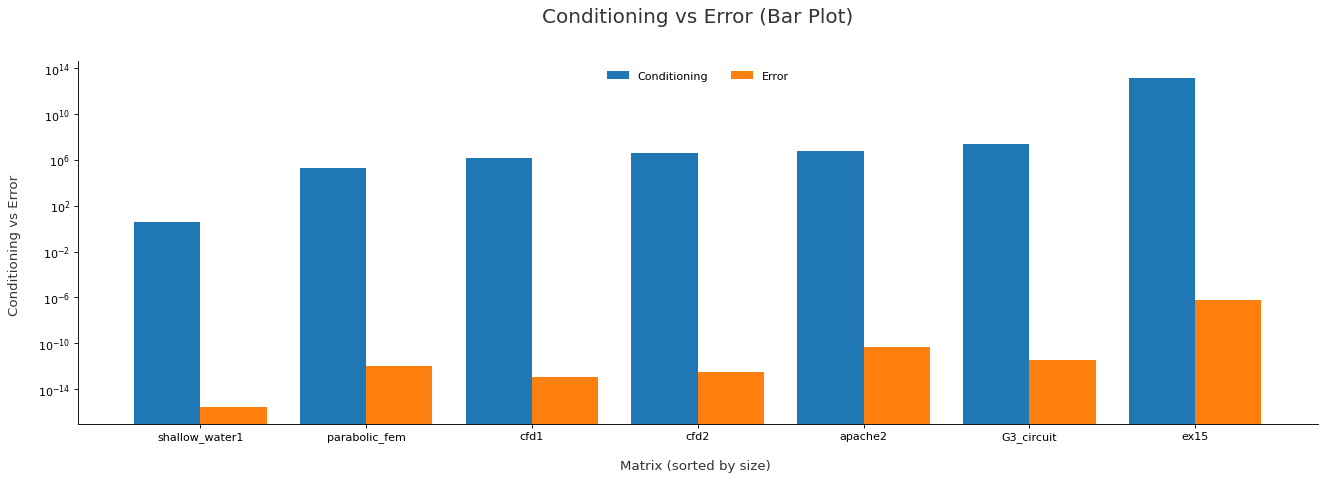

In [35]:
path = get_figures_path(folder_name, "cond_error_matlab_bar.png")
bar_plot(matrix_names, cond_list, error_list, "Matrix (sorted by size)", "Conditioning vs Error", "Conditioning vs Error", "Conditioning", "Error", path, LOG_SCALE=True)

## Coefficiente di Correlazione

0.92 per Python e 1 per MATLAB

Il Sistema Operativo non fa differenza

In [36]:
data = pd.read_csv(os.path.join(RESOURCES_DIRECTORY,"data.csv"))
data.sort_values(by="Rows", ascending=True, inplace=True)

data_mat = data[data.Language == 0]
data_mat_win = data_mat[data_mat.OS == 0]
data_mat_lin = data_mat[data_mat.OS == 1]

data_py = data[data.Language == 1]
data_py_win = data_py[data_py.OS == 0]
data_py_lin = data_py[data_py.OS == 1]

[[1. 1.]
 [1. 1.]]
The parameters of the line: [[4.43105858e-20]]


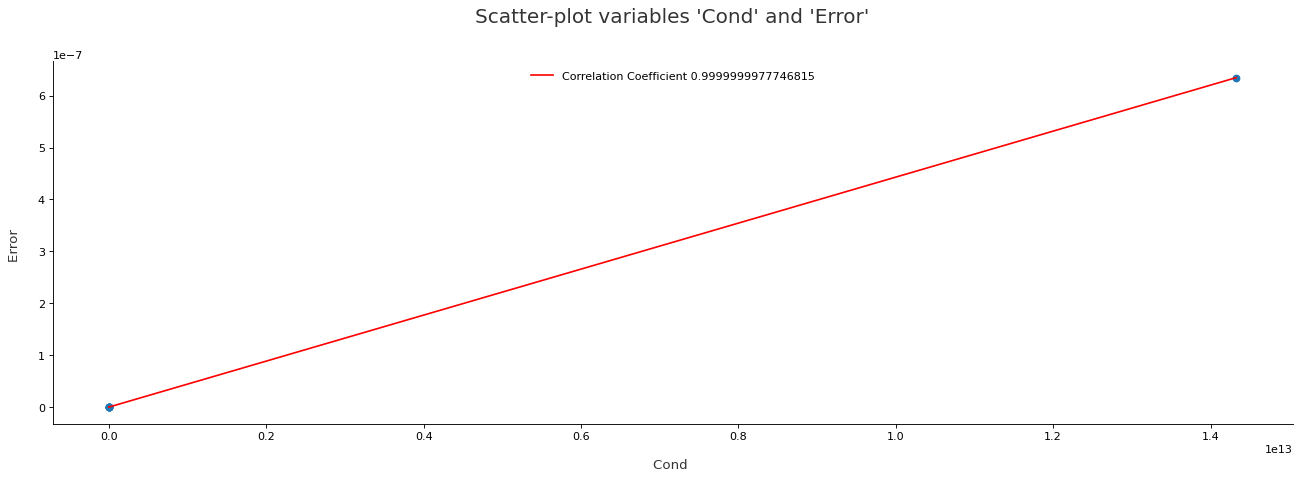

In [46]:
x = np.array(data_mat_lin['Cond'])
y = np.array(data_mat_lin['Error'])

path = get_figures_path(folder_name, "cond_error_coefficient_matlab.png")
correlation(x, y, "Cond", "Error", path)

[[1.         0.99999992]
 [0.99999992 1.        ]]
The parameters of the line: [[3.68600442e-18]]


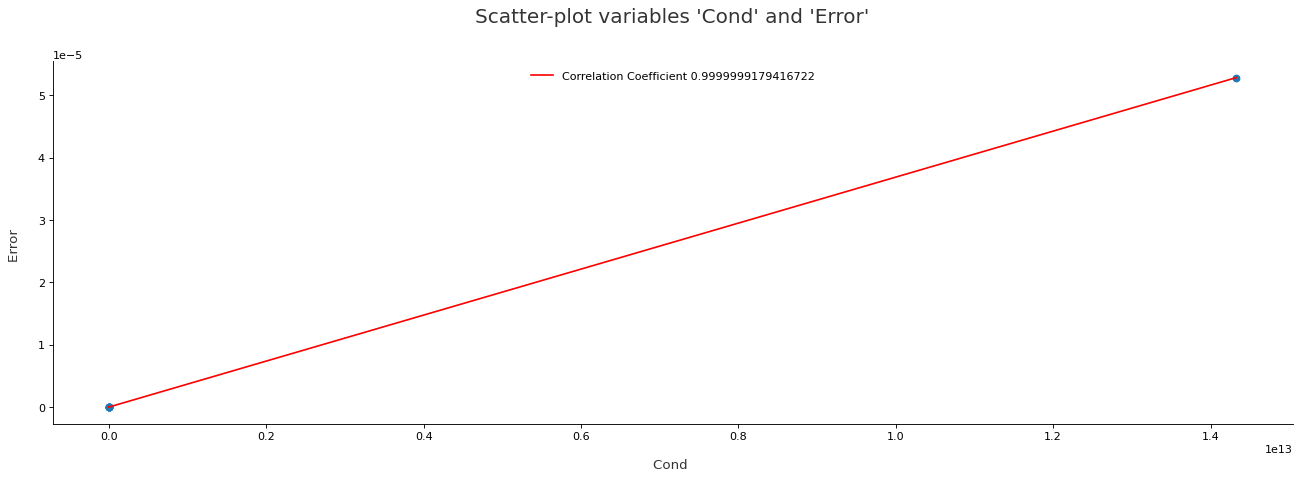

In [47]:
x = np.array(data_py_lin['Cond'])
y = np.array(data_py_lin['Error'])
# lo stesso vale per windows!

path = get_figures_path(folder_name, "cond_error_coefficient_python.png")
correlation(x, y, "Cond", "Error", path)

# Come aumenta il tempo di esecuzione in relazione alla Densità della Matrice?

Dalle analisi precedenti è emerso come il tempo di esecuzione non dipenda solamente dalla dimensione della matrice, ma anche dalla forma che i dati al suo interno assumono: una matrice grande, i cui dati sono distribuiti attorno alla diagonale principale, richiede meno tempo di una più piccola, i cui dati sono però più dispersi

Con questa analisi l'obiettivo è quello di capire se questa distribuzione dei dati è esprimibile attraverso un valore numerico, e verrà quindi analizzato se c'è una correlazione causale tra la densità della matrice (data dal rapporto dei valori non-zeri e la dimensione dell'intera matrice) e il tempo di esecuzione necessario per applicarvi la decomposizione di Cholesky

Non sembra però esserci correlazione, come mostrano i valori (-0.42 per MATLAB e -0.37 per Python), il che è dovuto al fatto che le matrici più dense risultano essere proprio quelle di dimensioni minori, e pertanto richiedono tempo minore di esecuzione nonostante il rapporto di valori diversi da zero rispetto al totale è più alto in proporzione

In [39]:
# Calcolo densità matrici

matrix_names = agg_data.Name.tolist()

agg_data["Density"] = agg_data.Nnz / ((agg_data.Rows)**2)
agg_data.head(len(agg_data))

agg_data.sort_values(by="Density", inplace=True)

density_list = agg_data.Density.tolist()


# Tempi per MATLAB e Python

time_list_mat = agg_data.timeMat.tolist()
time_list_py = agg_data.timePy.tolist()

## MATLAB

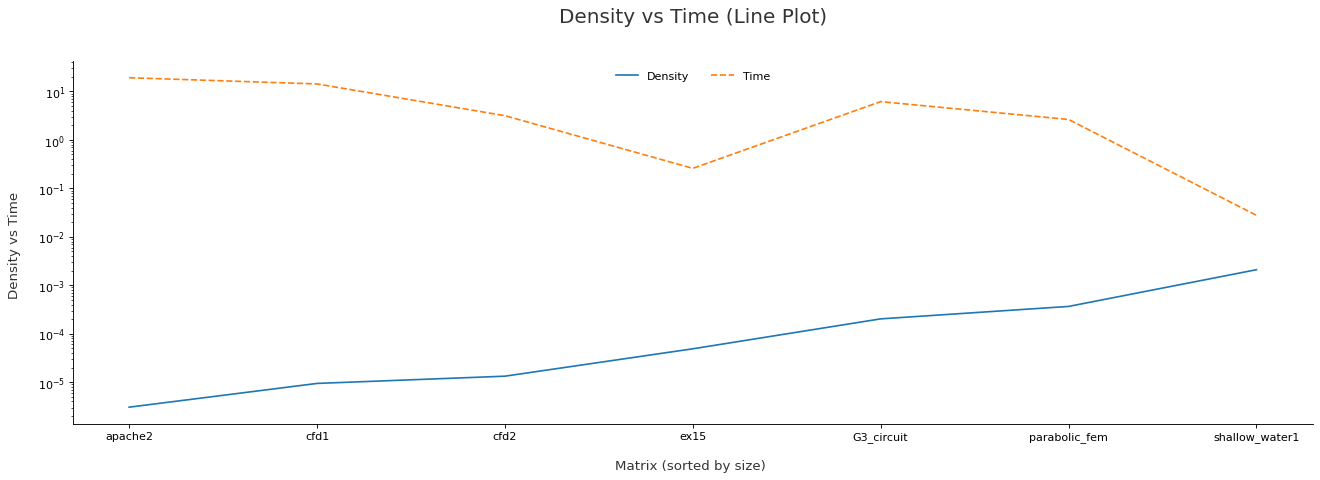

In [40]:
path = get_figures_path(folder_name, "density_time_matlab_line.png")

plot(matrix_names, density_list, time_list_mat, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", path, LOG_SCALE=True)

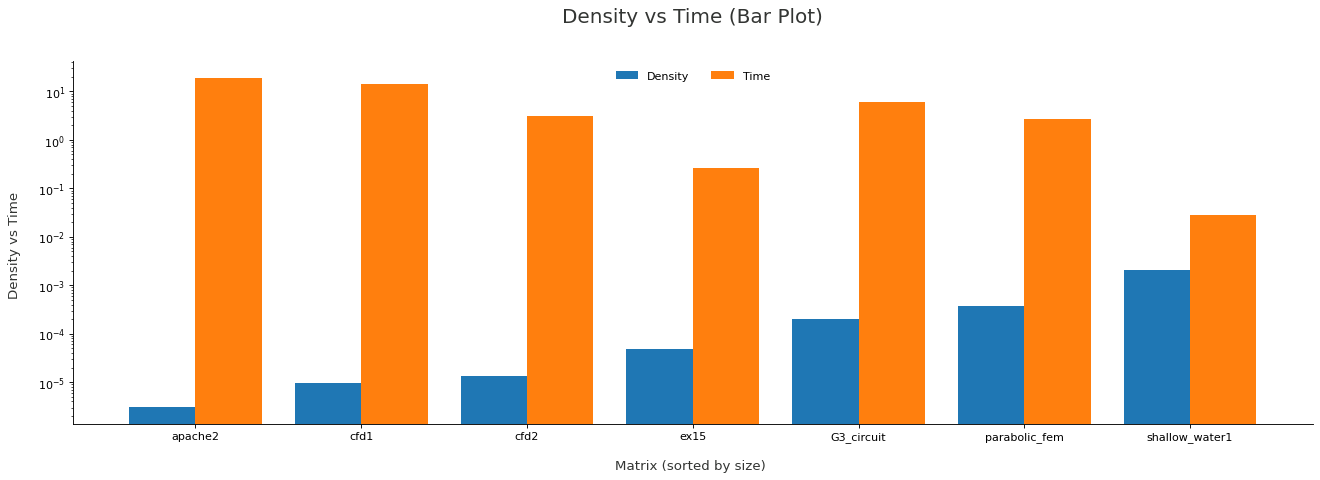

In [41]:
path = get_figures_path(folder_name, "density_time_matlab_bar.png")
bar_plot(matrix_names, density_list, time_list_mat, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", path, LOG_SCALE=True)

[[ 1.         -0.45334827]
 [-0.45334827  1.        ]]
The parameters of the line: [[-4402.07796943]]


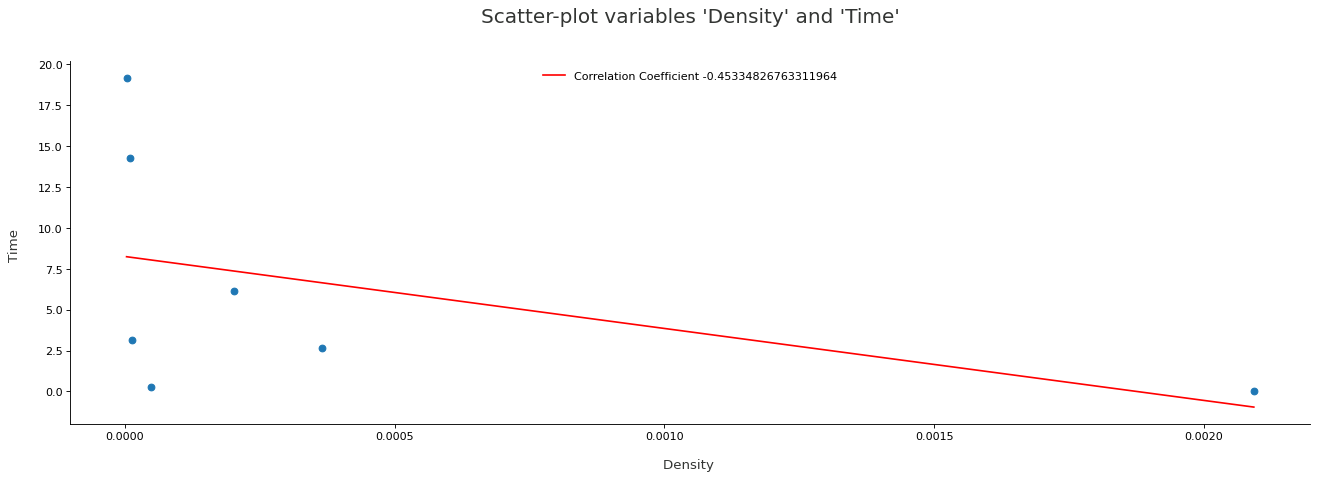

In [42]:
path = get_figures_path(folder_name, "density_time_coefficient_matlab.png")
correlation(density_list, time_list_mat, "Density", "Time", path)

## Python

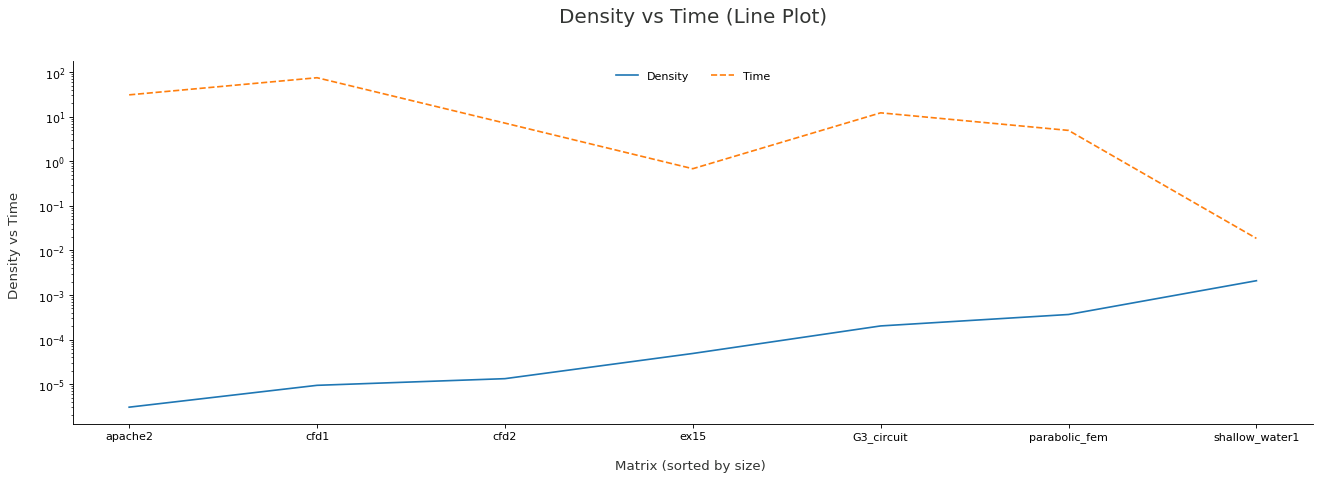

In [43]:
path = get_figures_path(folder_name, "density_time_python_line.png")

plot(matrix_names, density_list, time_list_py, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", path, LOG_SCALE=True)

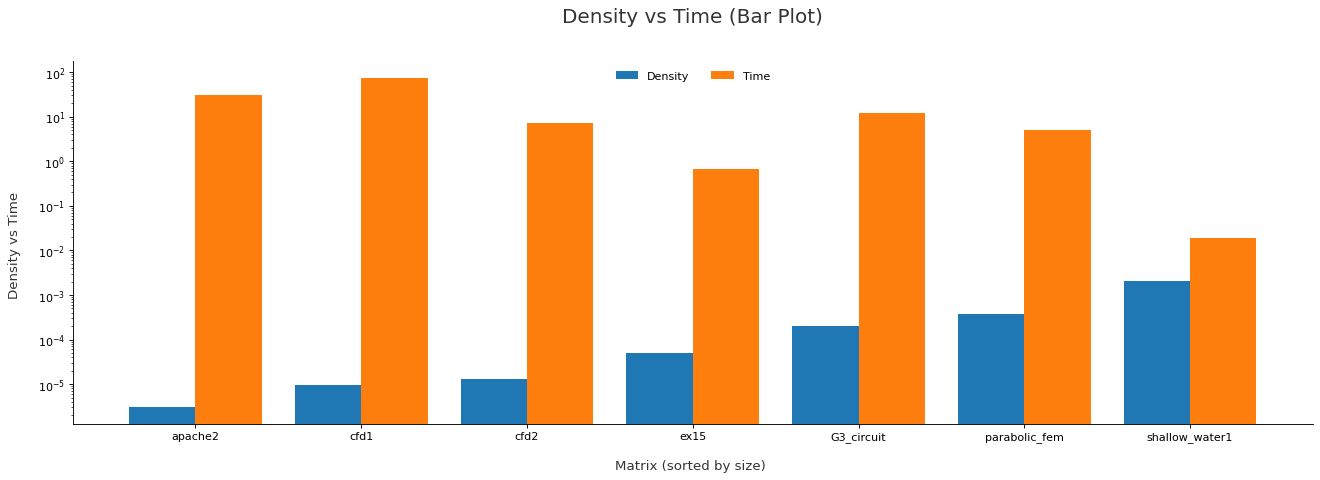

In [44]:
path = get_figures_path(folder_name, "density_time_python_bar.png")

bar_plot(matrix_names, density_list, time_list_py, "Matrix (sorted by size)", "Density vs Time", "Density vs Time", "Density", "Time", path, LOG_SCALE=True)

[[ 1.         -0.37275857]
 [-0.37275857  1.        ]]
The parameters of the line: [[-13141.88061703]]


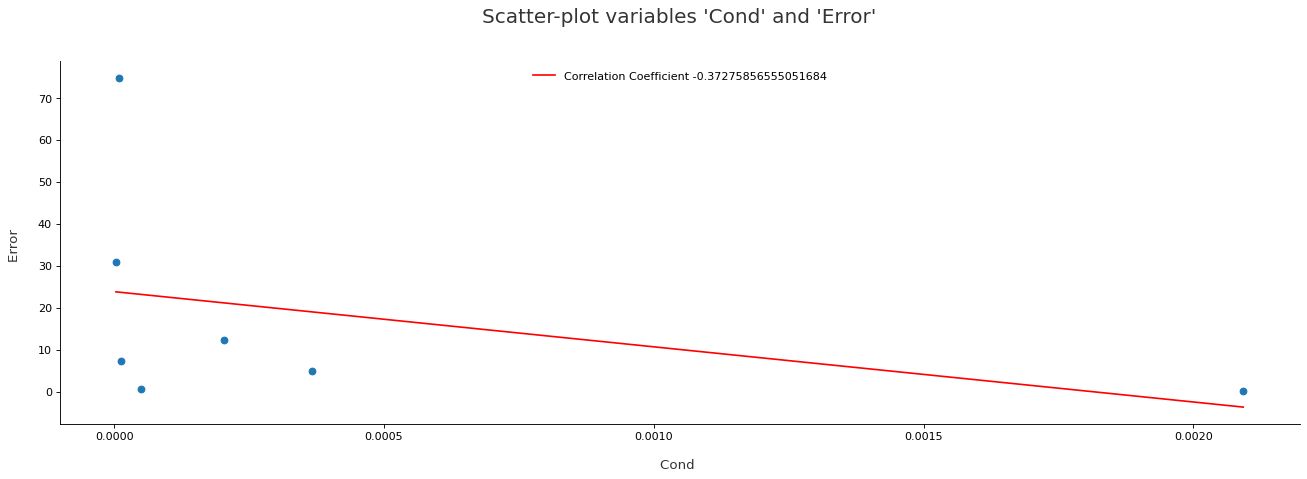

In [45]:
path = get_figures_path(folder_name, "density_time_coefficient_python.png")
correlation(density_list, time_list_py, "Cond", "Error", path)